In [1]:
import os
import sys
parent = os.path.abspath(os.path.join('./', os.pardir))
sys.path.insert(0, parent) # Add parent dirrectory to temporary path for imports

from nbp_helper_funs import *
from matplotlib import pyplot as plt

## Explanation

It has become apparent that analising the bulr of the numberplate image will become very important to cathegorize the difficult cases correctly). We have looked into implementing some deblurring algorithms but eventually settled on blurring our own (fitted by RMSSearch). In either case, we needed some method of blur detection.

To achive this we've straightened the plate and found the (root-mean-square) difference between it and it's binarised version. This would give large deifference score in any direction in which the plate has been blurred, but small score in unblurred direction. To correct for small dicrepancies in otherwise unblurred edges we've added a median-filter step too.

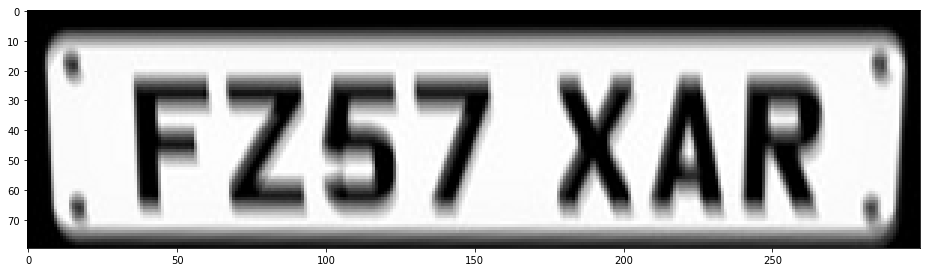

In [52]:
DIR = os.path.join(parent,'test subset','easy1.jpg')

im = Image.open(DIR).convert('L')
im = cropContourImg(im, pad=10)
im = straightenImage(im, getCorners(im))

plt.imshow(pil2np(im), cmap='gray')
plt.show()

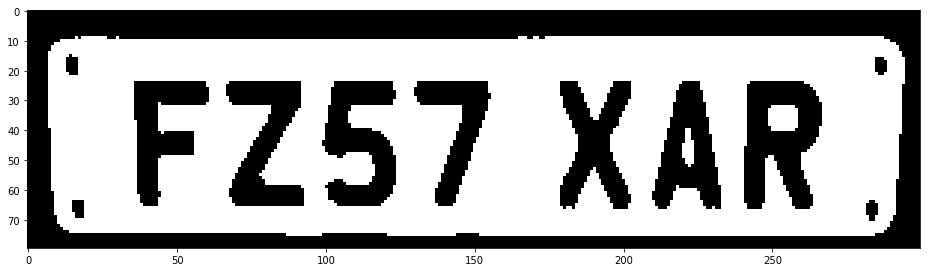

In [51]:
im_binarized = binarizeImage(im, threshold=0.5)

plt.imshow(pil2np(im_binarized), cmap='gray')
plt.show()

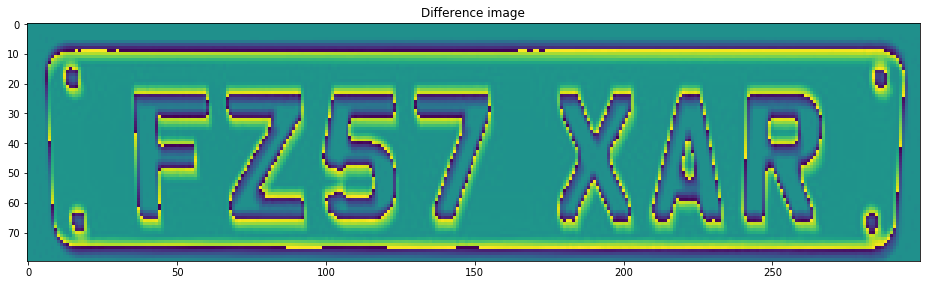

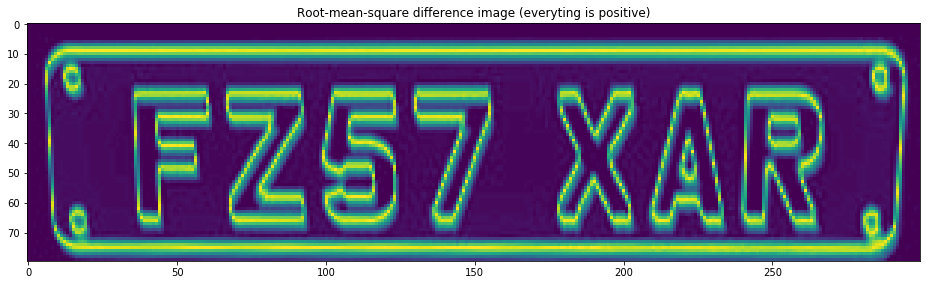

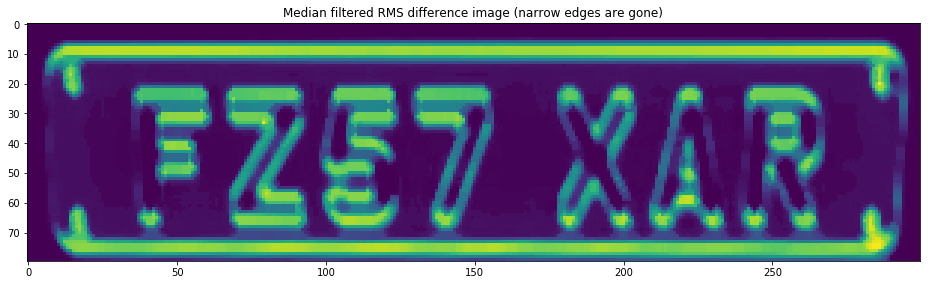

In [55]:
im_difference = pil2np(im_binarized) - pil2np(im)
im_rms_diff  = np.sqrt(im_difference**2) # Root mean square difference of the images
im_medfilt_diff = pil2np(np2pil(im_rms_diff).filter(ImageFilter.MedianFilter(5)))

plt.imshow(im_difference)
plt.title('Difference image')
plt.show()

plt.imshow(im_rms_diff)
plt.title('Root-mean-square difference image (everyting is positive)')
plt.show()

plt.imshow(im_medfilt_diff)
plt.title('Median filtered RMS difference image (narrow edges are gone)')
plt.show()

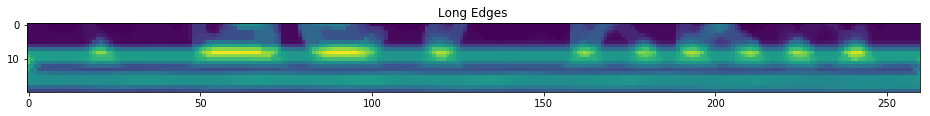

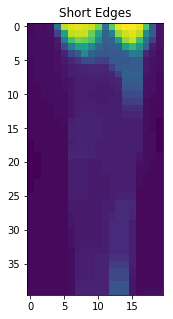

In [58]:
offset = 20 # offset number of pixels from top, bottom and sides

top = difference[0:offset, offset:-offset]
bottom = difference[-offset-1:-1, offset:-offset]
left = difference[offset: -offset, 0:offset]
right = difference[offset: -offset, -offset-1:-1]

long_edge = top + bottom
short_edge = left + right

plt.rcParams["figure.figsize"] = (16,5)
plt.imshow(long_edge)
plt.title('Long Edges')
plt.show()

plt.title('Short Edges')
plt.imshow(short_edge)
plt.show()

In [59]:
mean_long_edge = np.sum(long_edge)/np.prod(long_edge.shape)
mean_short_edge = np.sum(short_edge)/np.prod(short_edge.shape)

print(mean_long_edge, mean_short_edge)

non_blur_mean = 0.008 # Fudge factor

Up_blur = mean_long_edge/non_blur_mean - 1 
Right_blur = mean_short_edge/non_blur_mean - 1
print(Right_blur)
print('Long Edge Blur  = {:02.0f} pixels'.format(Up_blur))
print('Short Edge Blur = {:02.0f} pixels'.format(Right_blur))

0.255407239819 0.0439656862745
4.49571078431
Long Edge Blur  = 31 pixels
Short Edge Blur = 04 pixels


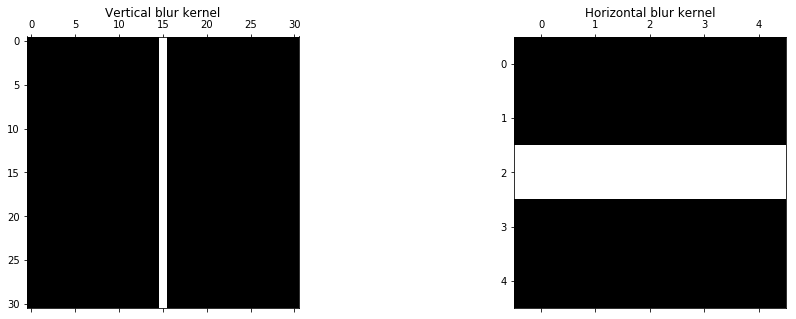

In [81]:
def getBlurKernel(blur, direction='v'):
    ''' Find the horizontal/vertical blur kernel
    '''
    size = blur/2 
    
    if int(size/2) == size/2: size += 1
    
    kernel = np.zeros((size, size))
    kernel[int((size - 1) / 2), :] = np.ones(size)
    
    if direction == 'h':
        pass
    elif direction == 'v':
        kernel = kernel.T
    
    return kernel / size

kernel1 = findMotionKernel(int(Up_blur),'v')
kernel2 = findMotionKernel(int(Right_blur),'h')
plt.subplot(1,2,1)
plt.spy(kernel1, cmap='gray')
plt.title('Vertical blur kernel')
plt.subplot(1,2,2)
# plt.imshow(kernel2, cmap='gray')
plt.spy(kernel2, cmap='gray')
plt.title('Horizontal blur kernel')
plt.show()